In [ ]:
# default_exp core

# shot_chart

> Plots the NBA shot_charts and shot distribution for players, teams and the whole league.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
from pathlib import Path
import os
import yaml
import pandas as pd
import requests
import tarfile
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, TypeVar, Union
from typing import Any, AnyStr, Callable, Collection, Dict, Hashable, Iterator, List, Mapping, NewType, Optional
import boto3
import hashlib
import shutil
import numpy as np
import inspect

In [ ]:
# export
class Config:
    config_path = Path(os.getenv('SHOTCHART_HOME', '~/.shot_chart')).expanduser()
    config_file = config_path/'config.yml'

    def __init__(self):
        self.config_path.mkdir(parents=True, exist_ok=True)
        if not self.config_file.exists(): self.create_config()
        self.d = self.load_config()

    def __getitem__(self,k):
        k = k.lower()
        if k not in self.d: k = k+'_path'
        if k in ["my_dpi","fig_height","fig_width"]:
            return self.d[k]
        return Path(self.d[k])

    def __getattr__(self,k):
        if k=='d': raise AttributeError
        return self[k]

    def __setitem__(self,k,v): self.d[k] = str(v)
    def __contains__(self,k): return k in self.d

    def load_config(self):
        with open(self.config_file, 'r') as f:
            config = yaml.safe_load(f)
            if 'version' in config and config['version'] == 1: return config
        self.create_config()
        return self.load_config()

    def create_config(self):
        F = plt.gcf()
        # Now check everything with the defaults:
        DPI = F.get_dpi()
        config = {'data_path':    str(self.config_path/'data'),
                  'archive_path':    str(self.config_path/'archive'),
                  'version':      1,
                  'my_dpi': DPI,
                  'fig_height': 472,
                  'fig_width': 500
                 }
        self.save_file(config)

    def save(self): self.save_file(self.d)
    def save_file(self, config):
        with self.config_file.open('w') as f: yaml.dump(config, f, default_flow_style=False)

In [ ]:
config = Config()

## URLs -

In [ ]:
# export
class URLs():
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()
    S3 = 'https://nba-shot-charts.s3.amazonaws.com/'

    SHOTS_2000    = f'{S3}shots-2000.tgz'
    SHOTS_2001    = f'{S3}shots-2001.tgz'
    SHOTS_2002    = f'{S3}shots-2002.tgz'
    SHOTS_2003    = f'{S3}shots-2003.tgz'
    SHOTS_2004    = f'{S3}shots-2004.tgz'
    SHOTS_2005    = f'{S3}shots-2005.tgz'
    SHOTS_2006    = f'{S3}shots-2006.tgz'
    SHOTS_2007    = f'{S3}shots-2007.tgz'
    SHOTS_2008    = f'{S3}shots-2008.tgz'
    SHOTS_2009    = f'{S3}shots-2009.tgz'
    SHOTS_2010    = f'{S3}shots-2010.tgz'
    SHOTS_2011    = f'{S3}shots-2011.tgz'
    SHOTS_2012    = f'{S3}shots-2012.tgz'
    SHOTS_2013    = f'{S3}shots-2013.tgz'
    SHOTS_2014    = f'{S3}shots-2014.tgz'
    SHOTS_2015    = f'{S3}shots-2015.tgz'
    SHOTS_2016    = f'{S3}shots-2016.tgz'
    SHOTS_2017    = f'{S3}shots-2017.tgz'
    SHOTS_2018    = f'{S3}shots-2018.tgz'
    SHOTS_2019    = f'{S3}shots-2019.tgz'

    def path(url, c_key='archive'):
        fname = url.split('/')[-1]
        local_path = URLs.LOCAL_PATH/('data' if c_key=='data' else 'archive')/fname
        if local_path.exists(): return local_path
        return Config()[c_key]/fname

## Downloading

In [ ]:
# export
def download_url(url, dest, overwrite=False, pbar=None, show_progress=True, chunk_size=1024*1024,
                 timeout=4, retries=5):
    "Download `url` to `dest` unless it exists and not `overwrite`"
    if os.path.exists(dest) and not overwrite: return

    s = requests.Session()
    s.mount('http://',requests.adapters.HTTPAdapter(max_retries=retries))
    # additional line to identify as a firefox browser, see fastai/#2438
    s.headers.update({'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'})
    u = s.get(url, stream=True, timeout=timeout)
    try: file_size = int(u.headers["Content-Length"])
    except: show_progress = False

    with open(dest, 'wb') as f:
        nbytes = 0
        if show_progress: pbar = progress_bar(range(file_size), leave=False, parent=pbar)
        try:
            if show_progress: pbar.update(0)
            for chunk in u.iter_content(chunk_size=chunk_size):
                nbytes += len(chunk)
                if show_progress: pbar.update(nbytes)
                f.write(chunk)
        except requests.exceptions.ConnectionError as e:
            fname = url.split('/')[-1]
            data_dir = dest.parent
            print(f'\n Download of {url} has failed after {retries} retries\n'
                  f' Fix the download manually:\n'
                  f'$ mkdir -p {data_dir}\n'
                  f'$ cd {data_dir}\n'
                  f'$ wget -c {url}\n'
                  f'$ tar xf {fname}\n'
                  f' And re-run your code once the download is successful\n')

In [ ]:
# export
def download_data(url, fname=None, c_key='archive', force_download=False):
    "Download `url` to `fname`."
    fname = Path(fname or URLs.path(url, c_key=c_key))
    fname.parent.mkdir(parents=True, exist_ok=True)
    if not fname.exists() or force_download: download_url(url, fname, overwrite=force_download)
    return fname

### Extract

In [ ]:
#export
def file_extract(fname, dest='.'):
    "Extract `fname` to `dest` using `tarfile` or `zipfile"
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

`file_extract` is used by default in `untar_data` to decompress the downloaded file.

In [ ]:
#export 
def _get_check(url):
    s3 = boto3.client('s3')
    s3_resp = s3.head_object(Bucket=URLs.S3.split(".")[0].split("//")[1],Key=url.split("/")[-1])
    ETag = s3_resp['ETag'].strip('"')
    # Open,close, read file and calculate MD5 on its contents 
    with open(Path(URLs.path(url)),"rb") as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        md5_returned = hashlib.md5(data).hexdigest()
    return ETag != md5_returned

In [ ]:
URLs.path(URLs.SHOTS_2019)

PosixPath('/Users/cesar.muro/.shot_chart/archive/shots-2019.tgz')

In [ ]:
#export
def untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=file_extract):
    "Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`."
    default_dest = URLs.path(url, c_key=c_key).with_suffix('.csv')
    dest = default_dest if dest is None else Path(dest)/default_dest.name
    fname = Path(fname or URLs.path(url))
    if fname.exists() and _get_check(url):
        print("A new version of this dataset is available, downloading...")
        force_download = True
    if force_download:
        if fname.exists(): os.remove(fname)
        if dest.exists(): os.remove(dest)
    if not dest.exists():
        fname = download_data(url, fname=fname, c_key=c_key)
        extract_func(fname, dest.parent)
    return dest

In [ ]:
#export
def make_df(path):
    "Creates a pandas dataframe from `path`"
    return pd.read_csv(path)

In [ ]:
shots_2019 = make_df(untar_data(URLs.SHOTS_2019))

In [ ]:
shots_2019.head()

,Unnamed: 0,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score
0,99,201910260ATL,2019,10,26,Atlanta,Orlando,168px,253px,"1st quarter, 11:47.0 remaining<br>Trae Young m...",11:47.0,1,Trae Young,made,2-pointer,14ft,Atlanta,2,0
1,0,201910260ATL,2019,10,26,Atlanta,Orlando,46px,232px,"1st quarter, 11:28.0 remaining<br>Aaron Gordon...",11:28.0,1,Aaron Gordon,missed,2-pointer,2ft,Orlando,2,0
2,1,201910260ATL,2019,10,26,Atlanta,Orlando,27px,240px,"1st quarter, 11:23.0 remaining<br>Aaron Gordon...",11:23.0,1,Aaron Gordon,made,2-pointer,1ft,Orlando,2,2
3,100,201910260ATL,2019,10,26,Atlanta,Orlando,216px,245px,"1st quarter, 11:10.0 remaining<br>Trae Young m...",11:10.0,1,Trae Young,made,2-pointer,18ft,Atlanta,4,2
4,101,201910260ATL,2019,10,26,Atlanta,Orlando,285px,177px,"1st quarter, 10:44.0 remaining<br>Alex Len mis...",10:44.0,1,Alex Len,missed,3-pointer,26ft,Atlanta,4,2


### Using the `delegate` function from https://www.fast.ai/2019/08/06/delegation/

In [ ]:
#export
def delegates(to=None, keep=False):
    "Decorator: replace `**kwargs` in signature with params from `to`"
    def _f(f):
        if to is None: to_f,from_f = f.__base__.__init__,f.__init__
        else:          to_f,from_f = to,f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v for k,v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        from_f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

## Creating a class - Shots

In [ ]:
#export
class Shots:
    "Plots shot chart and most/least effective shots using `plot_shots` and `plot_effective`"
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.__X_MODIFIER = 8
        self.__Y_MODIFIER = 466
        
    
    @property
    def teams(self):
        return self.dataframe['team'].drop_duplicates()
    
    @property
    def players(self):
        return self.dataframe['shots_by'].drop_duplicates()

    @property
    def fg_pct(self):
        return self.__calculate_metric(self.dataframe,"fg")
    
    @property
    def efg_pct(self):
        return self.__calculate_metric(self.dataframe,"efg")
    
    def __calculate_metric(self, dataframe, metric="efg"):
        if metric == "fg":
            return round(len(dataframe.loc[dataframe['outcome']=='made'])/len(dataframe),2)
        else:
            return round( (len(dataframe.loc[dataframe['outcome']=='made']) + 0.5 *len(dataframe.loc[(dataframe['outcome']=='made') & (dataframe['attempt']=='3-pointer')]))/len(dataframe),2)

    def calculate_metric(self, dataframe, metric="efg"):
        if metric == "fg":
            return round(len(dataframe.loc[dataframe['outcome']=='made'])/len(dataframe),2)
        else:
            return round( (len(dataframe.loc[dataframe['outcome']=='made']) + 0.5 *len(dataframe.loc[(dataframe['outcome']=='made') & (dataframe['attempt']=='3-pointer')]))/len(dataframe),2)

    def __plot_shot_chart(self, dataframe, made:bool=True,missed:bool=True,attempt:str="all", distances:Union[str,List[str]]="all"):
        plt.figure(figsize=(2 * Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
        plt.subplot(1, 2, 1)
        plt.title("Shot chart")
        img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
        implot = plt.imshow(img, extent=[0,500,0,472])
        if attempt == "2-pointer":
            if distances == "all":
                shots_df = dataframe.loc[dataframe["attempt"]=="2-pointer"]
            else:
                shots_df = dataframe.loc[(dataframe["attempt"]=="2-pointer") & (dataframe["distance"].isin(distances))]
        elif attempt == "3-pointer":
            if distances == "all":
                shots_df = dataframe.loc[dataframe["attempt"]=="3-pointer"]
            else:
                shots_df = dataframe.loc[(dataframe["attempt"]=="2-pointer") & (dataframe["distance"].isin(distances))]
        else:
            if distances == "all":
                shots_df = dataframe
            else:
                shots_df = dataframe.loc[dataframe["distance"].isin(distances)]
        #misses vs made
        if made:
            mades_df = shots_df.loc[shots_df['outcome']=='made']
            ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
            ys = [self.__Y_MODIFIER - int(x) for x in ys]
            xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
            xs = [x + self.__X_MODIFIER for x in xs]
            plt.scatter(xs,ys, color="g",alpha=1)
        if missed:
            misses_df = shots_df.loc[shots_df['outcome']=='missed']
            ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
            ys = [self.__Y_MODIFIER - int(x) for x in ys]
            xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
            xs = [x + self.__X_MODIFIER for x in xs]
            plt.scatter(xs,ys,marker="x", color="r",alpha=.3)
        return
    
    def __plot_scatter_volume(self, dataframe, fg_pct:float, efg_pct:float, most_or_least:str=None, final_distance:str=None, final_attempt:str=None,made:bool=True,missed:bool=True):
        if made:
            ax = plt.subplot(1, 2, 2)
            plt.title("Shot distribution - all distances")
            distances_all_shots = dataframe['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
            plt.hist(distances_all_shots, bins = range( 0, max(distances_all_shots)+1, 1), align="left")
            if most_or_least and final_distance and final_attempt:
                ax.text(30 + 12, 1, most_or_least+" effective shot: "+str(final_distance)+"\n Attempt: "+final_attempt+"\n\nMetrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
            else:
                ax.text(30 + 12, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
        return
    
    def list_game_ids(self,year,month,day):
        "Lists unique game ids in `dataframe` for a given date"
        return self.dataframe.loc[(self.dataframe['year']==year) & (self.dataframe['month']==month) & (self.dataframe['day']==day)][['game_id','winner','loser']].drop_duplicates()
    
    @delegates(__plot_shot_chart)
    def plot_shots(self,date_range:Union[str,tuple,int]="all",**kwargs):
        "Plots the shot chart for a given `date_range` including `made`, `missed` and `attempt` shots within `distances`"
        #use kwargs
        if date_range == "all":
            shots_df = self.dataframe
        elif type(date_range) == str:
            shots_df = self.dataframe.loc[self.dataframe['game_id']==date_range]
        elif type(date_range) == int:
            #means month
            shots_df = self.dataframe.loc[self.dataframe["month"]==date_range]
        else:
            copy_df = self.dataframe.copy()
            copy_df['Timestamp'] = pd.to_datetime(copy_df.loc[:][['year','month','day']])
            # Create a DatetimeIndex and assign it to the dataframe.
            copy_df.index = pd.DatetimeIndex(copy_df.Timestamp)
            shots_df = copy_df.loc[str(str(date_range[0][0])+"-"+str(date_range[0][1])+"-"+str(date_range[0][2])):str(str(date_range[1][0])+"-"+str(date_range[1][1])+"-"+str(date_range[1][2]))]
        self.__plot_shot_chart(shots_df, **kwargs)
        self.__plot_scatter_volume(shots_df, self.__calculate_metric(self.dataframe, "fg"), self.__calculate_metric(self.dataframe, "efg"))
        plt.show()
    
    @delegates(__plot_shot_chart)
    def plot_effective(self, most_or_least="most",metric:str="efg", min_shots:Union[str,int]="none", exclude:Union[str,List["str"]]="none", **kwargs):
        "Plots the shot chart based on `most_or_least` considering a given `metric` for `date_range` including `made`, `missed` and `attempt` shots within `distances`. You can optionally `exclude` some shots. The `min_shots` option lets you filter based on a minimum ammount of shots taken per distance, auto == uniform distribution [0ft,29ft] as tracked by https://stats.nba.com/players/shooting/?sort=25-29%20ft.%20FGA&dir=1&Season=2019-20&SeasonType=Regular%20Season&CF=PLAYER_NAME*E*"
        distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft"]
        distances = set(distances).intersection(set(self.dataframe['distance'].drop_duplicates().to_list()))
        if type(exclude) == list:
            distances = list(set(distances) - set(exclude))
        #if auto, use uniform distro
        if min_shots == "none":
            new_df = self.dataframe
        elif min_shots == "auto":
            min_value = round(len(self.dataframe)/30,0) # [0ft, 29ft]
            new_df = pd.DataFrame(columns = self.dataframe.columns)
            for distance in distances:
                if len(self.dataframe.loc[self.dataframe['distance']==distance]) >= min_value:
                    new_df = new_df.append(self.dataframe.loc[self.dataframe['distance']==distance])
        else:
            min_value = min_shots
            new_df = pd.DataFrame(columns = self.dataframe.columns)
            for distance in distances:
                if len(self.dataframe.loc[self.dataframe['distance']==distance]) >= min_value:
                    new_df = new_df.append(self.dataframe.loc[self.dataframe['distance']==distance])
        if most_or_least == "most":
            max_fg = -1
            max_efg = -1
            final_distance = ""
            for attempt in ["2-pointer", "3-pointer"]:
                for distance in distances:
                    player_df = new_df.loc[(new_df["distance"]==distance) & (new_df["attempt"]==attempt)]
                    if len(player_df) == 0:
                        continue
                    fg_pct = self.__calculate_metric(player_df, "fg")
                    efg_pct = self.__calculate_metric(player_df, "efg")
                    if metric == "fg":
                        if fg_pct > max_fg:
                            max_fg = fg_pct
                            max_efg = efg_pct
                            final_distance = distance
                            final_attempt = attempt
                    else:
                        if efg_pct > max_efg:
                            max_fg = fg_pct
                            max_efg = efg_pct
                            final_distance = distance
                            final_attempt = attempt
        else:
            max_fg = 101
            max_efg = 101
            final_distance = ""
            for attempt in ["2-pointer", "3-pointer"]:
                for distance in distances:
                    player_df = new_df.loc[(new_df["distance"]==distance) & (new_df["attempt"]==attempt)]
                    if len(player_df) == 0:
                        continue
                    fg_pct = self.__calculate_metric(player_df, "fg")
                    efg_pct = self.__calculate_metric(player_df, "efg")
                    if metric == "fg":
                        if fg_pct < max_fg:
                            max_fg = fg_pct
                            max_efg = efg_pct
                            final_distance = distance
                            final_attempt = attempt
                    else:
                        if efg_pct < max_efg:
                            max_fg = fg_pct
                            max_efg = efg_pct
                            final_distance = distance
                            final_attempt = attempt
        player_df = new_df.loc[(new_df["distance"]==final_distance) & (new_df["attempt"] == final_attempt)]
        self.__plot_shot_chart(player_df, **kwargs)
        all_shots = self.dataframe
        self.__plot_scatter_volume(all_shots, fg_pct=max_fg, efg_pct=max_efg, most_or_least=most_or_least, final_distance=final_distance, final_attempt=final_attempt)
        plt.show()

In [ ]:
shots = Shots(shots_2019)

In [ ]:
shots.players

0              Trae Young
1            Aaron Gordon
4                Alex Len
5           Evan Fournier
6         De'Andre Hunter
               ...       
149186     Chasson Randle
150693      Jarrod Uthoff
152069           Miye Oni
154039        Joe Chealey
159689      Dusty Hannahs
Name: shots_by, Length: 510, dtype: object

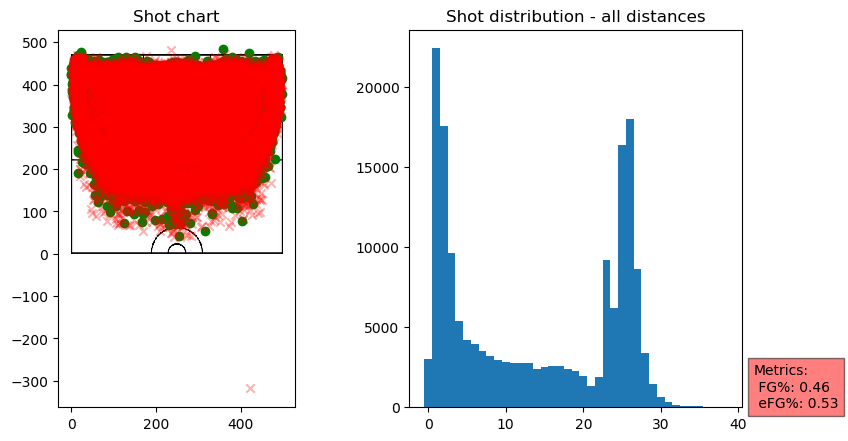

In [ ]:
shots.plot_shots()

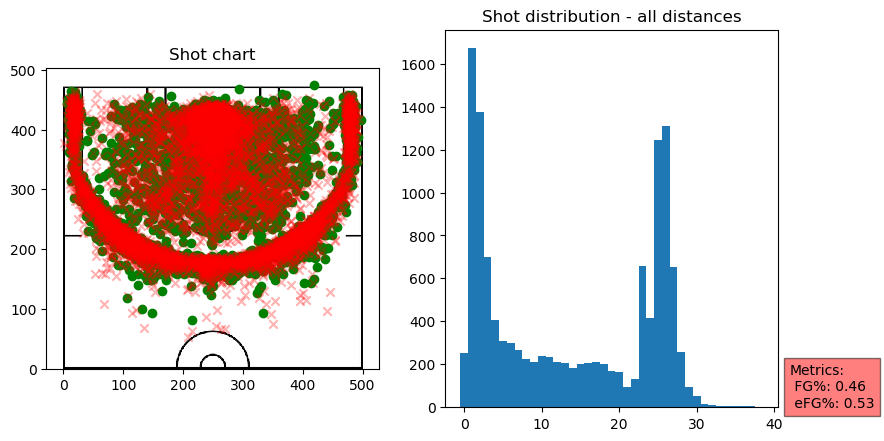

In [ ]:
shots.plot_shots(date_range=((2020,1,1), (2020,1,10)))

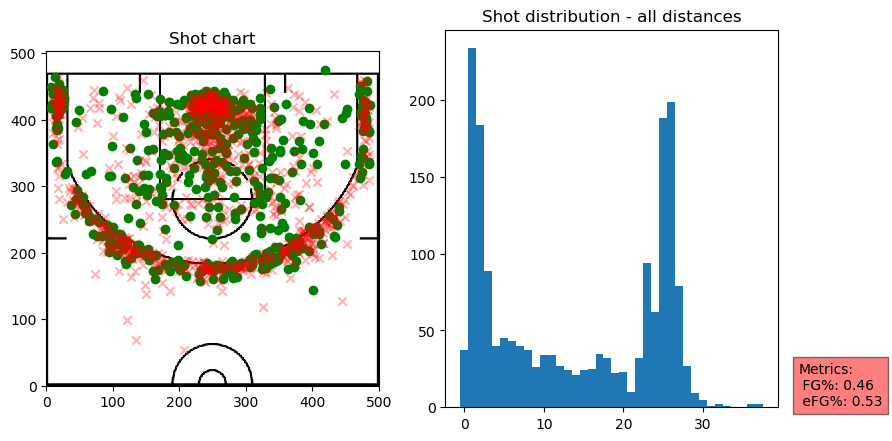

In [ ]:
shots.plot_shots(date_range=((2020,1,10), (2020,1,10)))

In [ ]:
shots.list_game_ids(2020, 2, 1)

,game_id,winner,loser
127424,202002010SAC,LA Lakers,Sacramento
127988,202002010WAS,Washington,Brooklyn
128182,202002010SAS,San Antonio,Charlotte
133145,202002010POR,Portland,Utah
133504,202002010ORL,Miami,Orlando
133663,202002010LAC,LA Clippers,Minnesota
133845,202002010IND,New York,Indiana
134003,202002010DAL,Dallas,Atlanta
134187,202002010CLE,Golden State,Cleveland
134371,202002010BOS,Boston,Philadelphia


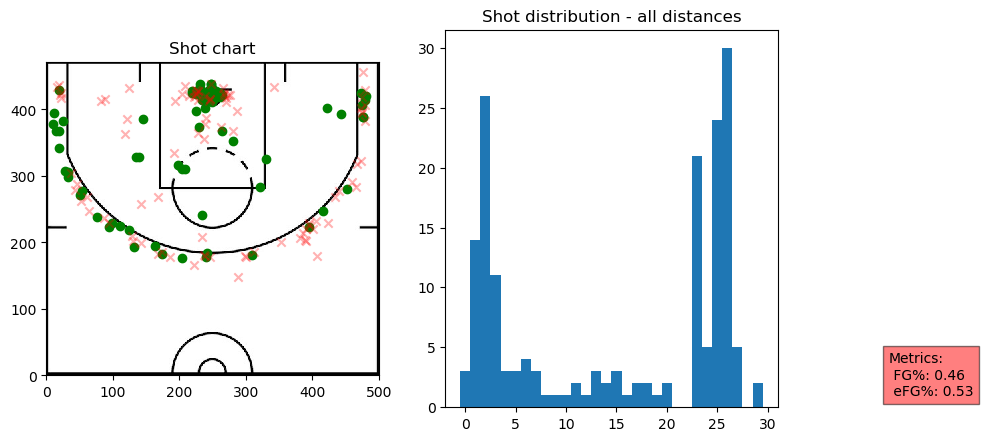

In [ ]:
shots.plot_shots(date_range="202002010SAC")

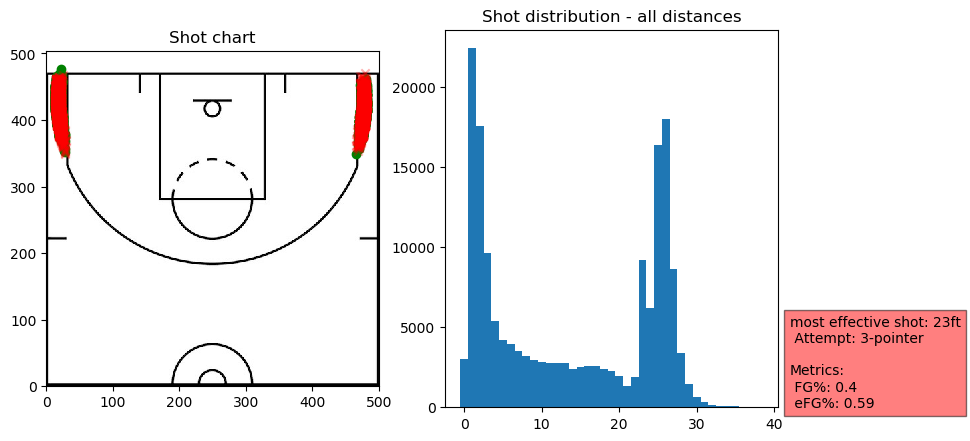

In [ ]:
shots.plot_effective(most_or_least="most", metric="efg", exclude=['0ft','1ft', '2ft'])

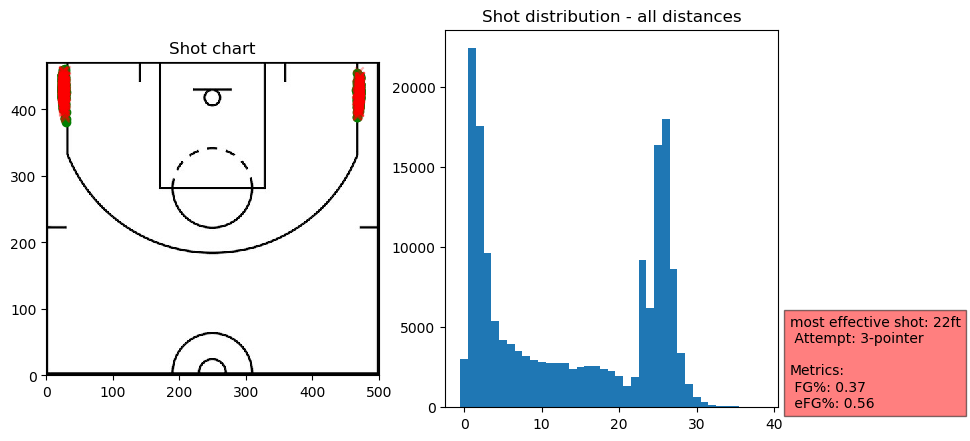

In [ ]:
shots.plot_effective(most_or_least="most", metric="efg", exclude=['0ft','1ft','2ft','23ft'])

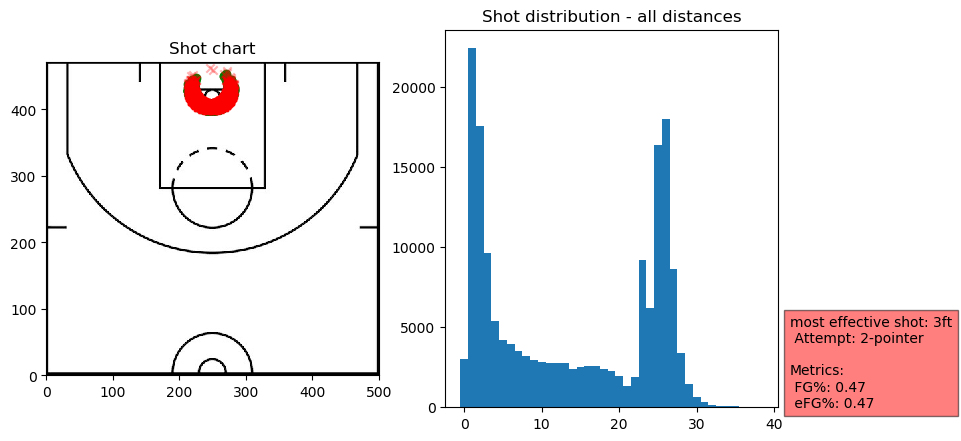

In [ ]:
shots.plot_effective(most_or_least="most", min_shots="auto",exclude=['1ft','2ft','23ft','24ft','25ft','26ft','27ft'])

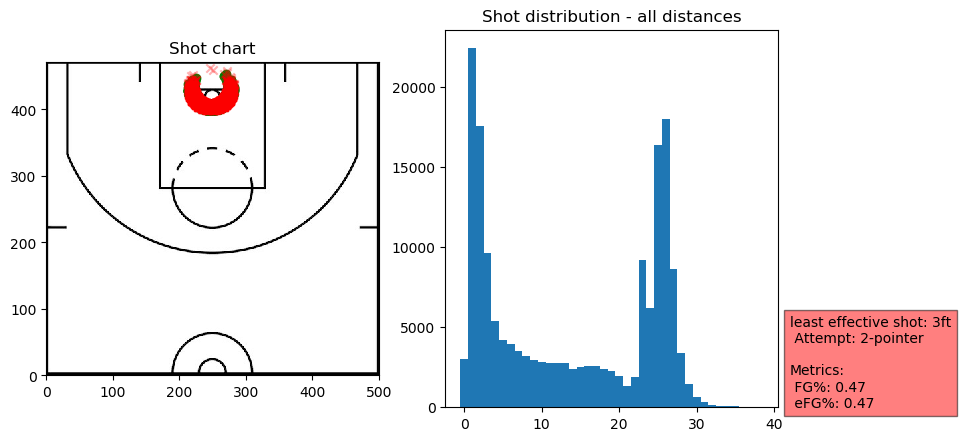

In [ ]:
shots.plot_effective(most_or_least="least", min_shots='auto',exclude=['24ft','23ft'])

## List teams

In [ ]:
#export
def list_teams(dataframe):
    "Lists all the teams in `dataframe`"
    return dataframe['team'].drop_duplicates()

In [ ]:
print(list_teams(shots_2019))

0            Atlanta
1            Orlando
183       Sacramento
184             Utah
341         Oklahoma
343     Golden State
511           Denver
512      New Orleans
675        Milwaukee
1016        Portland
1224         Phoenix
1226        Brooklyn
1412     San Antonio
1413         Memphis
1934         Toronto
2119    Philadelphia
2296       Minnesota
2477       LA Lakers
2655         Houston
2656     LA Clippers
2843       Charlotte
3017          Boston
3018      Washington
3383         Detroit
3918           Miami
5020       Cleveland
5535         Indiana
6407        New York
6410         Chicago
8473          Dallas
Name: team, dtype: object


## List unique game ids

In [ ]:
#export
def list_game_ids(dataframe,year,month,day):
    "Lists unique game ids in `dataframe` for a given date"
    return dataframe.loc[(dataframe['year']==year) & (dataframe['month']==month) & (dataframe['day']==day)][['game_id','winner','loser']].drop_duplicates()
    

In [ ]:
list_game_ids(shots_2019,2019,11,25)

,game_id,winner,loser
40400,201911250ATL,Minnesota,Atlanta
41460,201911250TOR,Toronto,Philadelphia
41631,201911250SAS,LA Lakers,San Antonio
41979,201911250MIL,Milwaukee,Utah
42161,201911250MIA,Miami,Charlotte
42325,201911250IND,Indiana,Memphis
42516,201911250GSW,Oklahoma City,Golden State
43049,201911250DET,Detroit,Orlando
43212,201911250CLE,Brooklyn,Cleveland
45560,201911250CHI,Portland,Chicago


## Inheriting from Shots to create TeamShots

In [ ]:
#export
class TeamShots(Shots):
    "Team shots"
    def __init__(self, dataframe, team):
        dataframe = dataframe.loc[dataframe['team']==team].copy()
        self.team = team
        super().__init__(dataframe)

In [ ]:
team_shots = TeamShots(shots_2019,"Portland")

In [ ]:
team_shots.team

'Portland'

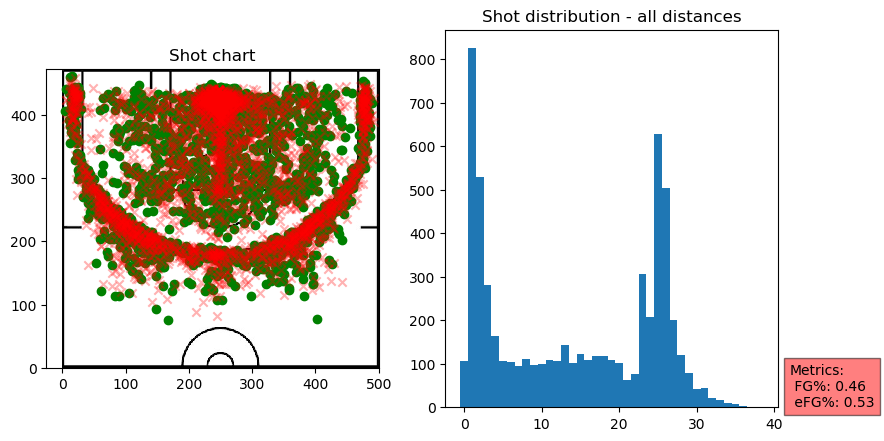

In [ ]:
team_shots.plot_shots()

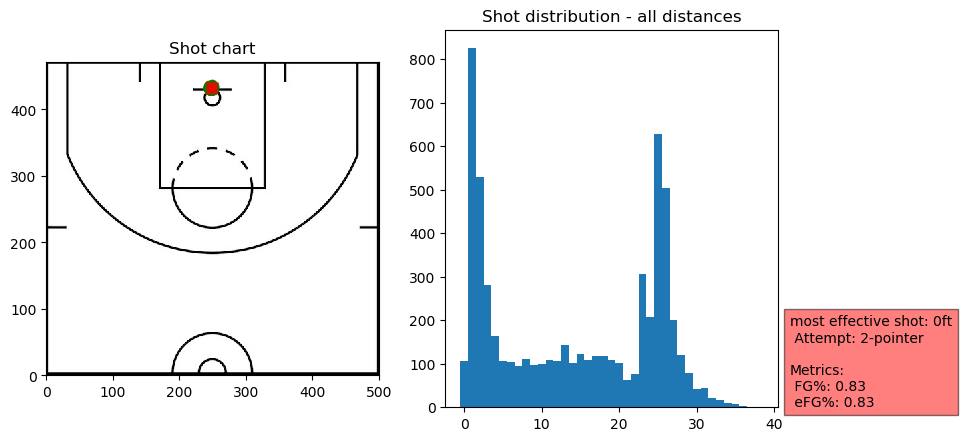

In [ ]:
team_shots.plot_effective()

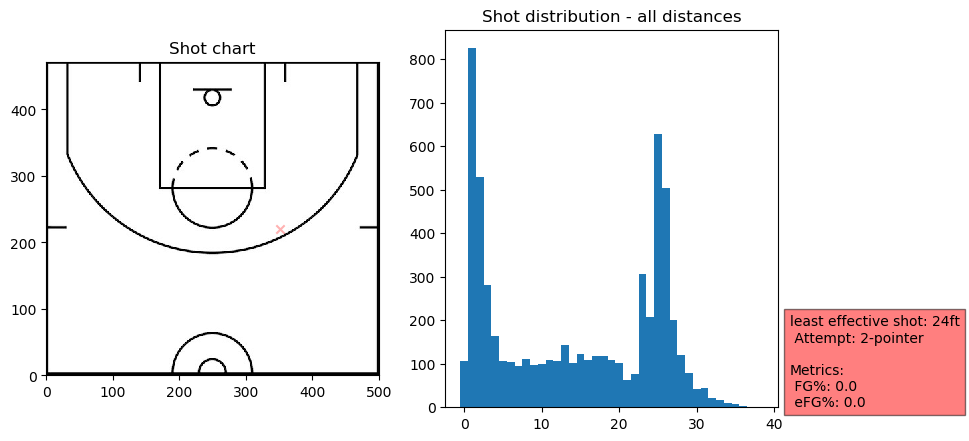

In [ ]:
team_shots.plot_effective(most_or_least="least")

In [ ]:
team_shots = TeamShots(shots_2019,"Houston")

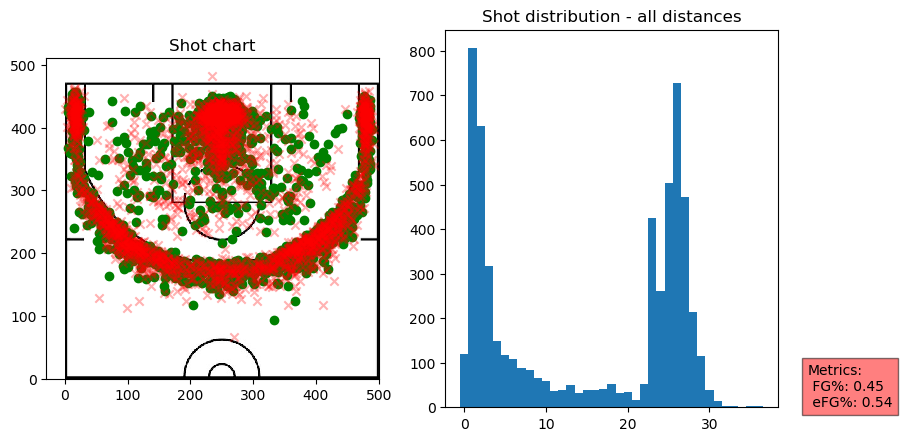

In [ ]:
team_shots.plot_shots()

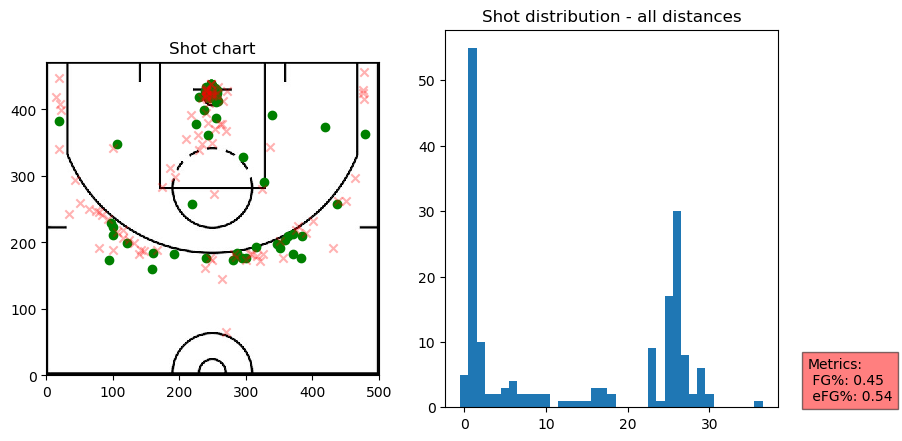

In [ ]:
team_shots.plot_shots(date_range=((2020,1,3), (2020,1,8)))

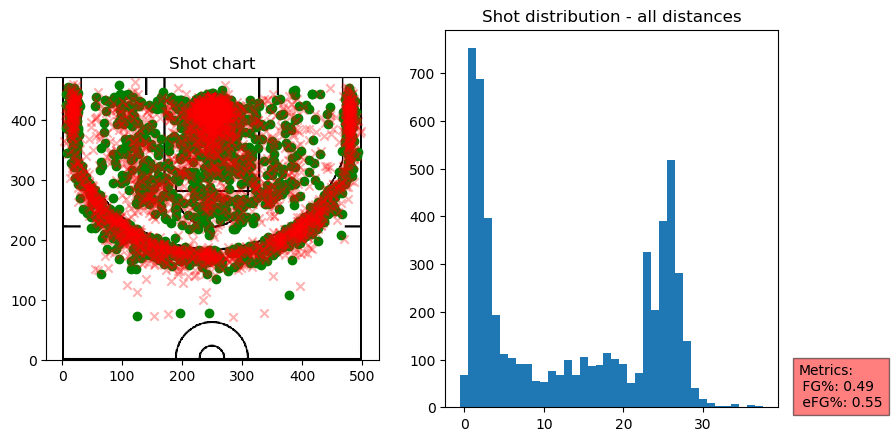

In [ ]:
team_shots = TeamShots(shots_2019,"LA Lakers")
team_shots.plot_shots()

## List players who took shots for a team

In [ ]:
#export
def list_team_players(dataframe, team):
    "Lists the players in `dataframe` who took shots for a `team`"
    return dataframe.loc[dataframe['team']==team].groupby('shots_by').shots_by.count().reset_index(name='count').sort_values(['count'], ascending=False)

In [ ]:
list_team_players(shots_2019,'LA Lakers')

,shots_by,count
9,LeBron James,1175
1,Anthony Davis,990
8,Kyle Kuzma,585
7,Kentavious Caldwell-Pope,465
3,Danny Green,425
2,Avery Bradley,382
12,Rajon Rondo,327
5,JaVale McGee,282
0,Alex Caruso,259
4,Dwight Howard,257


## Inheriting from Shots to create PlayerShots

In [ ]:
#export
class PlayerShots(Shots):
    "Player shots"
    def __init__(self, dataframe, player):
        self.team_total_shots = len(dataframe.loc[dataframe['team'] == dataframe.loc[dataframe['shots_by']==player]['team'].to_list()[0]])
        dataframe = dataframe.loc[dataframe['shots_by']==player].copy()
        self.player = player
        super().__init__(dataframe)
    

In [ ]:
player_shots = PlayerShots(shots_2019,"Anthony Davis")

In [ ]:
player_shots.fg_pct

0.51

In [ ]:
player_shots.efg_pct

0.55

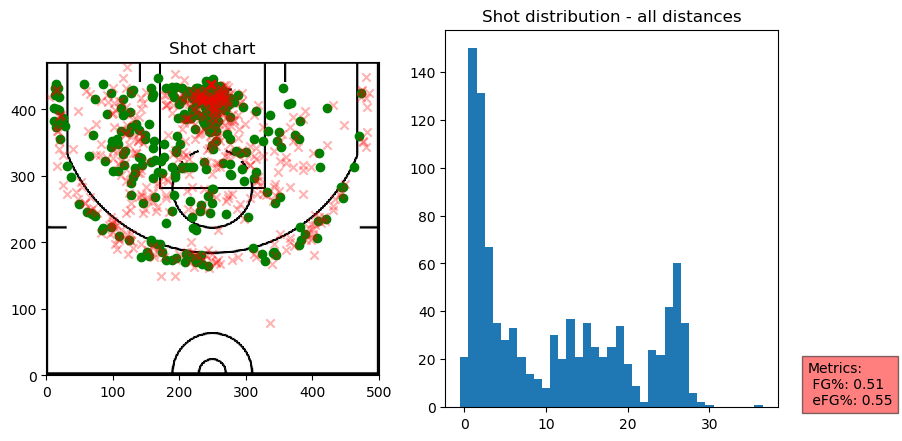

In [ ]:
player_shots.plot_shots()

In [ ]:
player_shots = PlayerShots(shots_2019,"D'Angelo Russell")

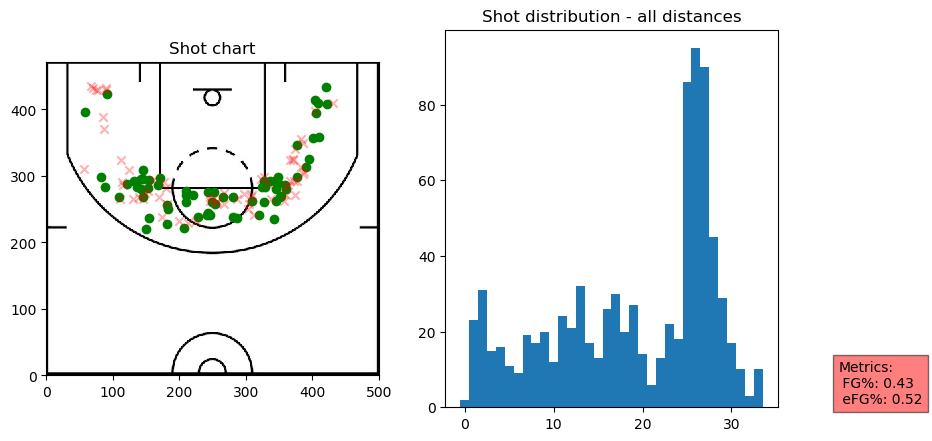

In [ ]:
player_shots.plot_shots(distances=["16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft"],attempt="2-pointer")

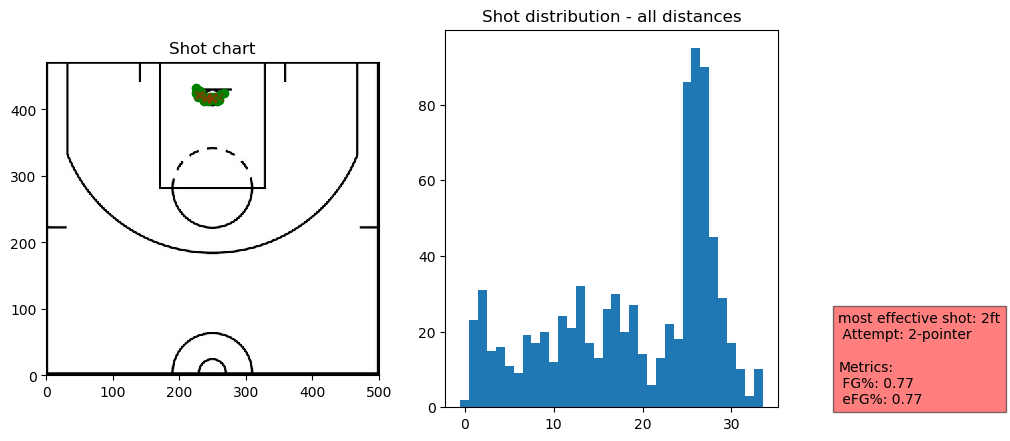

In [ ]:
player_shots.plot_effective(metric="efg", exclude=['0ft','22ft',"1ft"])

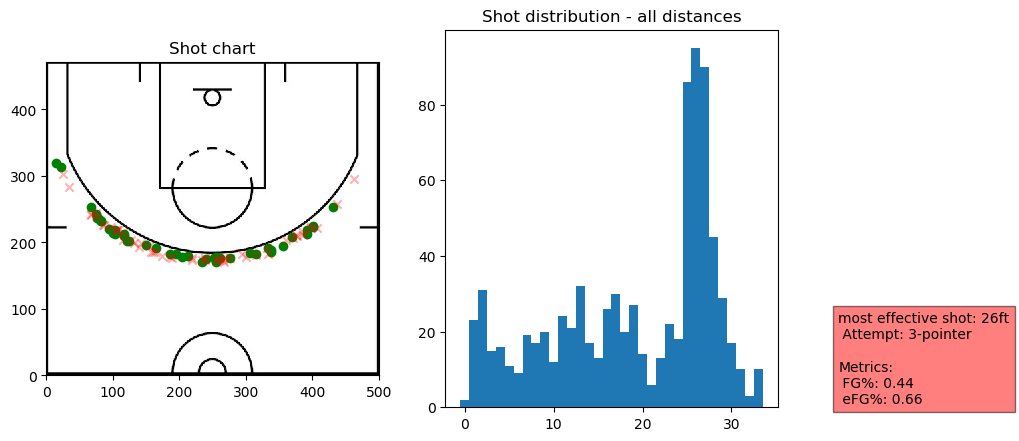

In [ ]:
player_shots.plot_effective(metric="efg", min_shots="auto",exclude=['2ft'])

In [ ]:
player_shots = PlayerShots(shots_2019,"James Harden")

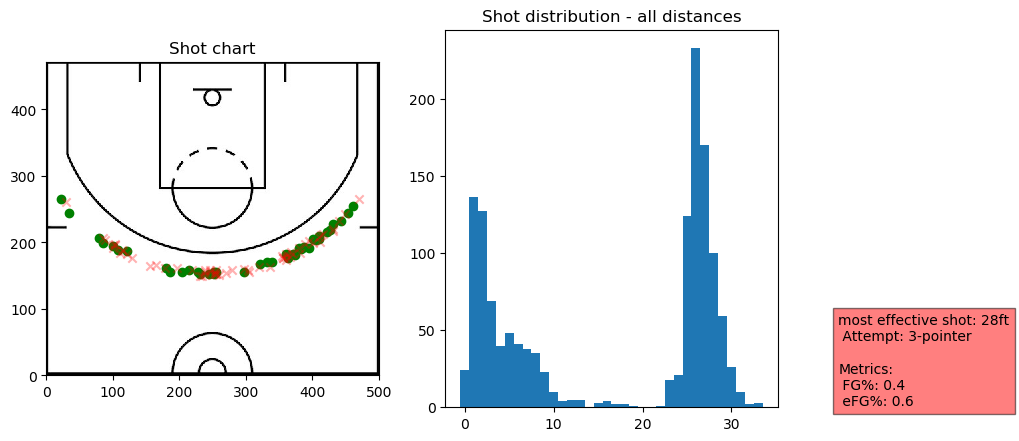

In [ ]:
player_shots.plot_effective(metric="efg", exclude=['16ft',"0ft","11ft",'1ft'])

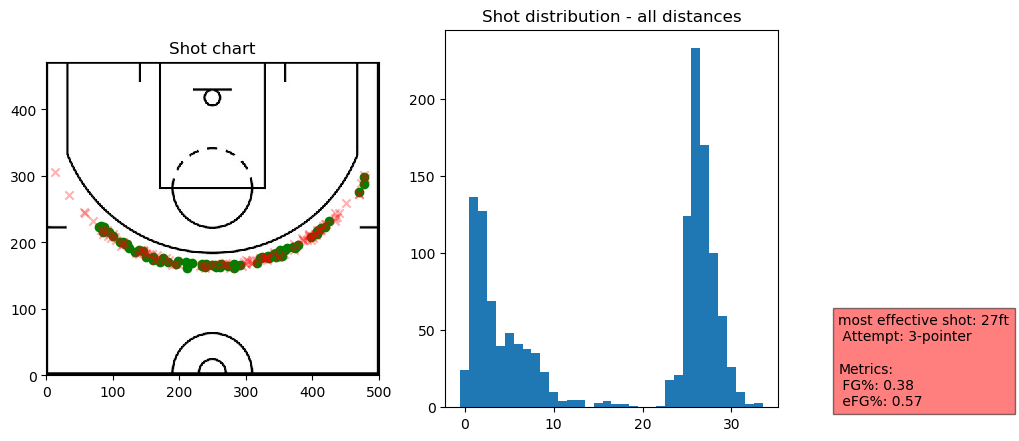

In [ ]:
player_shots.plot_effective(min_shots="auto",exclude=['1ft','28ft','2ft','3ft'])

In [ ]:
player_shots = PlayerShots(shots_2019, 'Derrick Rose')

In [ ]:
player_shots.list_game_ids(2019,12,1)

,game_id,winner,loser
51034,201912010DET,Detroit,San Antonio


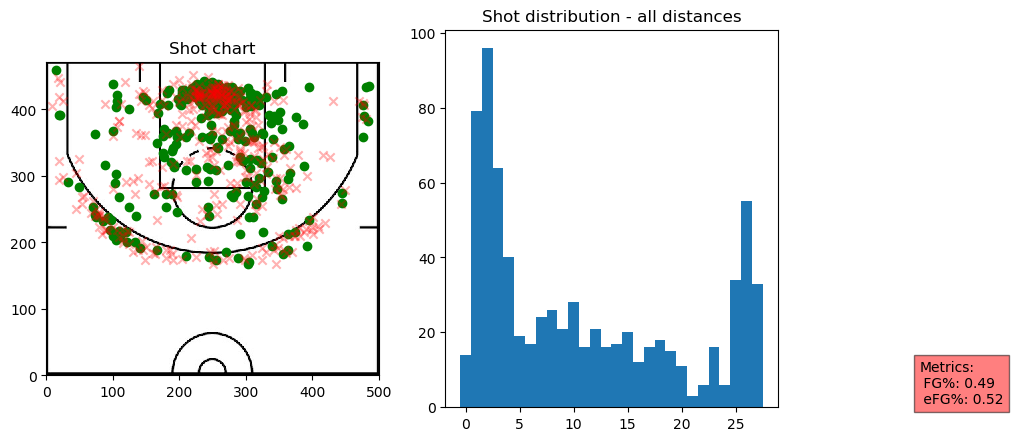

In [ ]:
player_shots.plot_shots()

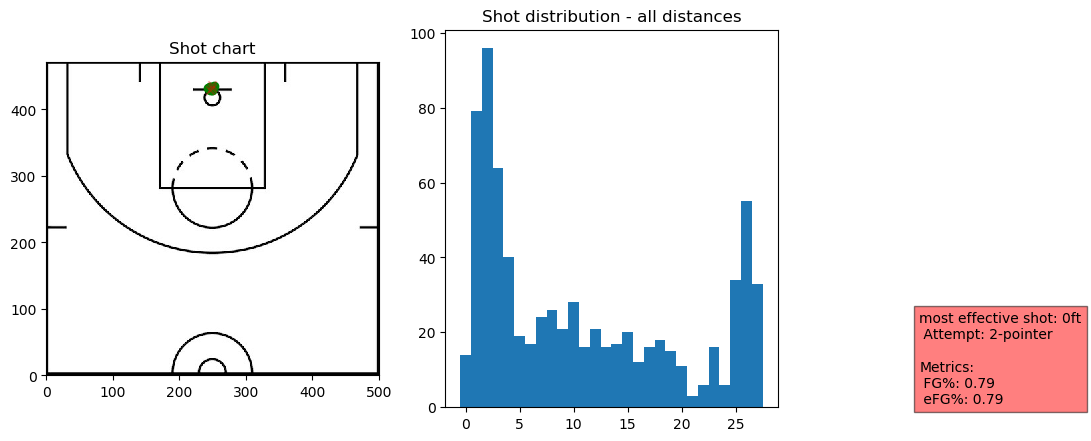

In [ ]:
player_shots.plot_effective()

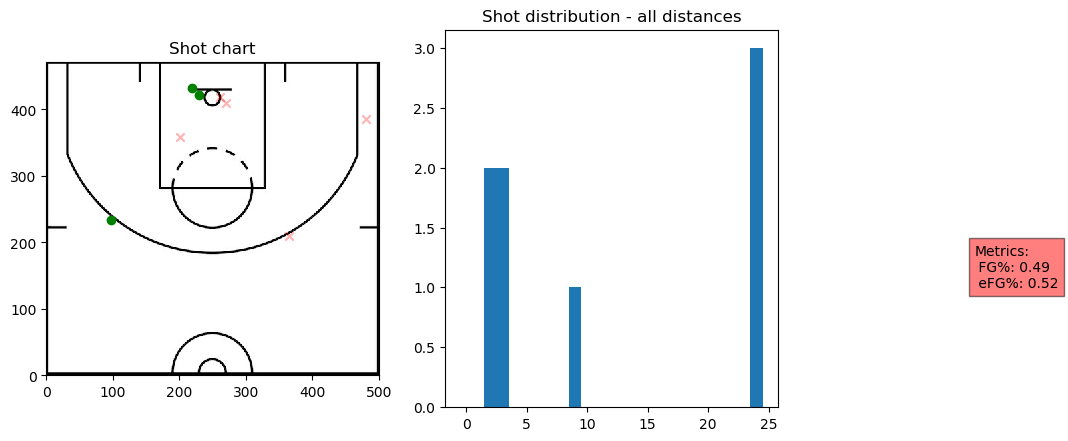

In [ ]:
player_shots.plot_shots(date_range='201912010DET')

## Export -